___

<a href='https://github.com/eliasmelul/'> <img src='https://s3.us-east-2.amazonaws.com/wordontheamazon.com/NoMargin_NewLogo.png' style='width: 15em;' align='right' /></a>
# Finance with Python
### Monte Carlo Simulations for Stock Price Predictions
___
<h4 align="right">by Elias Melul, Data Scientist </h4> 

___



In this notebook, we introduce how to use Monte Carlo simulations for forecasting future stock prices.

$$
{Price Today}={Price Yesterday * e^r}
$$

* We know yesterday's price. 

* We want to predict today's price. 

* What we do not know is the rate of return, r, of the share price between yesterday and today. 

This is where the Monte Carlo simulation comes in! But first, how do we compute the return?

### Brownian Motion

Brownian motion will be the main driver for estimating the return. It is a stochastic process used for modeling random behavior over time. For simplicity, we will use regular brownian motion, instead of the Geometric Brownian Motion, which is more common and less questionable in stock pricing applications.

**Brownian Motion** has two main main components:
1. Drift - the direction that rates of returns have had in the past. That is, the expected return of the stock.
$$
{Drift} = ({mean} - \frac{1}{2} {Var})
$$

    Why do we multiply the variance by 0.5? Because historical values are eroded in the future.
    

2. Volatility -  random variable. This is the historical volatility multiplied by a random, standard normally distributed variable.

$$
{Volatility} = {Std.Dev. * Z([Rand(0;1)])}
$$

Therefore, our asset pricing equation ends up looking like this:

$$
{Price Today}={Price Yesterday * e^{mean-\frac{1}{2}{Var} + Std.Dev * Z([Rand(0;1)])}}
$$



This technique will be used for every day into the future you want to predict, and for however many trials the monte carlo simulation will run!

---

First, import required libraries.

In [134]:
import numpy as np
import pandas as pd
#from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime
import os

%matplotlib inline

In [135]:
# set Variables
os.environ['API_KEY'] = 'XXXXXX'
tickers = ['AMP']  # Example tickers
days=180


Import data for one or multiple stocks from a specified date until the last available data. Data source: yahoo finance.

For this, it's better if we define a function that imports stock(s) daily data for any publicly traded company as defined by the user starting at a user-defined date until today. We will use the Adjusted Close price.

In [136]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from datetime import datetime

# Function to import stock data using Alpha Vantage
def import_stock_data_alphavantage(tickers, api_key, start='2024-1-01', end=datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    ts = TimeSeries(key=api_key, output_format='pandas')  # Initialize TimeSeries with your API key
    if isinstance(tickers, str):
        tickers = [tickers]  # Convert to list if only one ticker is provided
    for ticker in tickers:
        # Get the stock data
        df, meta_data = ts.get_daily_adjusted(ticker, outputsize='full')
        # Selecting only the '5. adjusted close' column and renaming it to the ticker
        df = df['5. adjusted close'].rename(ticker).to_frame()
        # Filter the data based on the start and end dates
        df = df[(df.index >= start) & (df.index <= end)]
        # If data is empty, initialize it with the current df
        if data.empty:
            data = df
        else:
            # If not empty, join the new df with the existing data
            data = data.join(df, how='outer')
    return data



In [137]:
# Example usage
api_key = os.environ.get('API_KEY')
data = import_stock_data_alphavantage(tickers, api_key)
print(data.head())


               AMP
date              
2024-02-02  390.69
2024-02-01  386.02
2024-01-31  386.83
2024-01-30  393.55
2024-01-29  393.11


Then, we compute the logarithmic returns of the data.

In [138]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [139]:
log_return = log_returns(data)

We also create a function to compute the simple returns.

In [140]:
def simple_returns(data):
    return ((data/data.shift(1))-1)

## CAPM and Sharpe

Before we jump into Monte Carlo Simulations, we would like to report some statistics with it, including the Beta and Sharpe Ratio of the stock, compared to the _market portfolio_. To understand these metrics, we first must understand the underlying concepts of the _Capital Asset Pricing Model,_ starting with the _market portfolio_.

* The market portfolio is the theoretical combination of all possible investments in the world. However, there is no such thing as a market portfolio. We approximate it with a stock market index. In our case, we use the S&P500, but you can specify any index you want to!

* We also note that there is no such thing as a risk-free asset. We will use a 10-year US government bond yield of 2.5% instead.

* The equity premium is the difference between the expected return of the market and the risk-free asset. This value is typically between 4.5 and 5.5%. We can use 5%.

We use the _market portfolio_ to compute the Beta, the CAPM expected return, and the Sharpe Ratio of a stock.
1. **Beta**: measures the market risk that cannot be avoided through diversification. This is the relationship between the stock and the market portfolio. In other words, it is a measure of how much risk the investment will add to a portfolio that looks like the market.
##### $$ 
\beta_{i} = \frac{\sigma_{i,m}}{\sigma_{m}^2}
$$

        When beta = 0, it means that there's no relationship.
    
        When beta < 1, it means that the stock is defensive (less prone to high highs and low lows)
    
        When beta > 1, it means that the stock is aggresive (more prone to high highs and low lows)
    
    
2. **Expected Return CAPM**: calculates the expected return of a security adjusted to the risk taken. This equates to the return expected from taking the extra risk of purchasing this security.
##### $$
\overline{r_{i}} = r_f + \beta_{i}(\overline{r_{m}} - r_f) 
$$

3. **Sharpe Ratio**: measures the performance of a security compared to a risk-free asset, after adjusting for its risk. This is the excess return per unit of risk of an investment.
##### $$
Sharpe = \frac{\overline{r_{i}} - r_f}{\sigma_{i}}
$$
        When Sharpe > 1, GOOD risk-adjusted returns
    
        When Sharpe > 2, VERY GOOD risk-adjusted returns
    
        When Sharpe > 3, EXCELLENT risk-adjusted returns
    

In [141]:
def market_data_combination(data, mark_ticker = "SPY", start='2022-1-1'):
    api_key = os.environ.get('API_KEY')
    market_data = import_stock_data_alphavantage(mark_ticker, api_key)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    # Add debugging statements here
    print("Market data shape:", market_data.shape)
    print("Number of non-NaN entries in market data:", sum(~market_data.isna().values.flatten()))
    print("First few rows of market data:\n", market_data.head())
    return data, ann_return

In [142]:
def beta_sharpe(data, mark_ticker = "SPY", start='2010-1-1', riskfree = 0.025):
    
    """
    Input: 
    1. data: dataframe of stock price data
    2. mark_ticker: ticker of the market data you want to compute CAPM metrics with (default is ^GSPC)
    3. start: data from which to download data (default Jan 1st 2010)
    4. riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    print("printing dd")
    print(dd.head())
    print("printing mark_ret")
    print(mark_ret)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"SPY":"Beta"}, inplace=True)
    
    return beta

In [143]:
print(data)
beta_sharpe(data)

               AMP
date              
2024-02-02  390.69
2024-02-01  386.02
2024-01-31  386.83
2024-01-30  393.55
2024-01-29  393.11
2024-01-26  391.40
2024-01-25  391.38
2024-01-24  389.46
2024-01-23  387.80
2024-01-22  387.11
2024-01-19  381.67
2024-01-18  374.88
2024-01-17  372.06
2024-01-16  373.47
2024-01-12  376.40
2024-01-11  378.27
2024-01-10  377.99
2024-01-09  375.91
2024-01-08  384.44
2024-01-05  382.10
2024-01-04  379.04
2024-01-03  380.54
2024-01-02  379.03
Market data shape: (23, 1)
Number of non-NaN entries in market data: 23
First few rows of market data:
                SPY
date              
2024-02-02  494.35
2024-02-01  489.20
2024-01-31  482.88
2024-01-30  490.89
2024-01-29  491.27
printing dd
               AMP     SPY
date                      
2024-02-02  390.69  494.35
2024-02-01  386.02  489.20
2024-01-31  386.83  482.88
2024-01-30  393.55  490.89
2024-01-29  393.11  491.27
printing mark_ret
[-0.40200844]


Beta       STD      CAPM    Sharpe
AMP  0.776008  0.147075 -0.306362 -2.253011

**Brownian Motion**

Now that we have our returns, we can compute the brownian motion, as explained in the introduction.
1. Calculate the drift
2. Calculate the variance
3. Calculate the daily returns based on the drift and variance

In [144]:
def drift_calc(data, return_type='log'):
    try:
        if return_type == 'log':
            lr = log_returns(data)
        elif return_type == 'simple':
            lr = simple_returns(data)
        u = lr.mean()
        var = lr.var()
        drift = u - (0.5 * var)
        return drift.values
    except Exception as e:
        print(f"Error in drift_calc: {str(e)}")
        print("Please check the input data and return type")
        return None


In [145]:
drift_calc(data)
print(drift_calc(data))

[-0.00142049]


We calculated the drift above, but now, we must calculate the daily returns for the data. There are things to consider:
1. How many days into the future will we predict? (How many rows)
2. How many iterations of these predictions will we compute? (How many columns)

This generates the daily returns (not prices!) for each day into the future for each iteration (simulation) based on a normal distribution.

In [146]:
import numpy as np
from scipy.stats import norm  # Add this import statement
# Other necessary imports...

def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type == 'simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()
    
    # Oftentimes, we find that the distribution of returns is a variation of the normal distribution where it has a fat tail
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr


In [147]:
dr = daily_returns(data, 2, 3)

**Note**: This next function is used to calculate the probability of a stock having a higher price or higher returns than specified over the period defined. 

In [148]:
def probs_find(predicted, higherthan, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

Example: We would like to find out the probability that our investment in PG will breakeven or make a profit over the course of a year (financial year is about 252 days). There are two ways we can do this:
1. Returns = 0
2. Final stock price = initial stock price ($44.05 - Jan 1st 2010, the first data point)

So, with the simulation predicted values, we will predict said probabilities.

---

First, however, we must run the simulation! How does it work?

1. Calculate the daily returns for every day and every iteration (simulation) of the data. 
2. Creates an equally large matrix of size [days x iteration] full of zeroes.
3. Input the last stock price value in the first row (day 0) of the "empty" matrix (part 2). This is our starting point.
4. Calculate "today's price" based on yesterday's multiplied by the daily return generated. That is, multiply the daily return generated for every simulation with the stock price calculated for the previous day (the previous row) for every simulation.

Does that sounds familiar? The fourth step multiplies the daily returns with the price of the stock of the previous day!

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)

/tmp/ipykernel_5723/256993402.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax[0])
/tmp/ipykernel_5723/256993402.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])


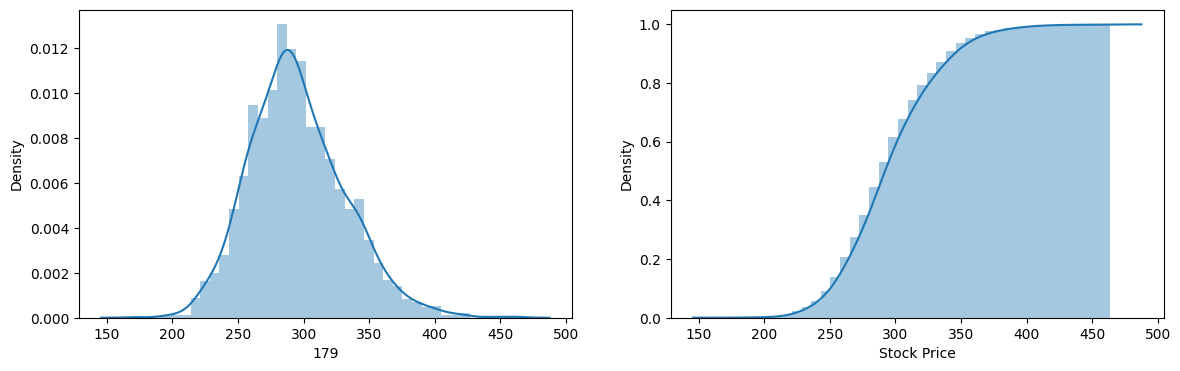

AMP
Days: 179
Expected Value: $295.29
Return: -28.36%
Probability of Breakeven: 0.021


0           1           2           3           4           5     \
0    379.030000  379.030000  379.030000  379.030000  379.030000  379.030000   
1    379.352661  381.714966  383.375358  374.618161  379.056080  383.724965   
2    383.591870  383.667919  387.326043  378.040984  383.788079  384.552494   
3    386.108322  387.878792  384.256772  375.464701  387.219939  381.711610   
4    381.631130  392.071871  386.789258  379.043435  388.119138  384.337388   
..          ...         ...         ...         ...         ...         ...   
175  274.620651  327.468959  338.998329  311.132089  277.171998  268.362211   
176  273.823051  330.329240  340.157730  315.772843  276.109058  271.104723   
177  268.611234  327.913665  340.507277  315.386937  280.087126  272.714697   
178  267.943621  326.330867  336.213854  313.826748  278.087766  266.557115   
179  265.070193  326.852844  335.912955  317.773837  275.479935  263.751964   

           6           7           8           9     ...        1990  \
0    379.030000  379.030000  379.030000  379.030000  ...  379.030000   
1    379.268473  383.107347  375.761131  376.028392  ...  378.794027   
2    380.759779  380.522154  375.154570  374.085927  ...  387.705626   
3    381.759838  377.722111  380.351716  369.994757  ...  382.980634   
4    382.796217  378.511563  382.213891  369.667710  ...  377.895425   
..          ...         ...         ...         ...  ...         ...   
175  296.044323  272.474672  258.583479  323.754294  ...  308.143244   
176  290.589379  271.241683  259.441422  322.390141  ...  309.378225   
177  286.569191  269.093063  260.158056  321.484201  ...  311.814690   
178  284.299963  267.645930  258.882895  318.415170  ...  311.421097   
179  286.049375  263.748028  259.920448  315.868492  ...  309.732946   

           1991        1992        1993        1994        1995        1996  \
0    379.030000  379.030000  379.030000  379.030000  379.030000  379.030000   
1    375.038490  375.485313  375.864464  382.186543  377.960955  378.357218   
2    373.992699  376.977980  375.518888  382.730319  379.596358  375.710396   
3    377.054784  373.449616  372.747890  379.812307  374.961612  371.970980   
4    370.365979  374.697049  370.855179  376.347085  370.040956  367.751955   
..          ...         ...         ...         ...         ...         ...   
175  306.289989  293.509720  238.018586  241.767277  276.028667  331.820011   
176  304.545964  300.364879  239.519264  242.484682  279.416244  330.770579   
177  309.325043  295.015790  240.915226  241.481323  279.862726  328.342621   
178  307.198771  294.829539  239.443694  240.116965  283.072914  327.138140   
179  307.898267  298.888811  238.543232  244.912671  282.958299  326.508719   

           1997        1998        1999  
0    379.030000  379.030000  379.030000  
1    384.599065  377.076425  376.789847  
2    379.918507  375.128224  378.423115  
3    378.593563  374.644340  381.921425  
4    373.388293  377.899273  379.154510  
..          ...         ...         ...  
175  274.102543  318.014381  367.952975  
176  271.380431  317.868825  375.309240  
177  267.904477  316.983911  377.162959  
178  265.037441  314.558325  375.887249  
179  263.808481  314.730609  380.917933  

[180 rows x 2000 columns]

In [150]:
simulate_mc(data, days, 2000, 'log')

Now, let's loop through all the stated securities and generate the visualizations and statistics that will help us understand the expected performance of a stock.

In [151]:
def monte_carlo(tickers, days_forecast, iterations, start_date = '2000-1-1', return_type = 'log', plotten=False):
    api_key = os.environ.get('API_KEY')
    data = import_stock_data_alphavantage(tickers, api_key)
    inform = beta_sharpe(data, mark_ticker="SPY", start=start_date)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

In [152]:
start = "2015-1-1"
days_to_forecast= 252
simulation_trials= 10000
ret_sim_df = monte_carlo(['GOOG','AAPL'], days_forecast= days_to_forecast, iterations=simulation_trials,  start_date=start, plotten=False)

Market data shape: (23, 1)
Number of non-NaN entries in market data: 23
First few rows of market data:
                SPY
date              
2024-02-02  494.35
2024-02-01  489.20
2024-01-31  482.88
2024-01-30  490.89
2024-01-29  491.27
printing dd
              GOOG    AAPL     SPY
date                              
2024-01-02  139.56  185.64  472.65
2024-01-03  140.36  184.25  468.79
2024-01-04  138.04  181.91  467.28
2024-01-05  137.39  181.18  467.92
2024-01-08  140.53  185.56  474.60
printing mark_ret
[-0.40200844]
Error in drift_calc: 'numpy.float64' object has no attribute 'values'
Please check the input data and return type


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'